In [3]:
import os
import sys
import json
import numpy as np
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision
import torch.nn.utils.spectral_norm as spectralnorm
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from pytorch_msssim import ms_ssim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from models import *
from utils import *
from helper import *
from vimeo90k import Vimeo90kDataset, VideoFolder_diffusion
from ssf_model import ScaleSpaceFlow

thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)

from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.models.image_model import IntraNoAR
from DCVC_HEM.src.utils.common import str2bool, interpolate_log, create_folder, generate_log_json, dump_json
from DCVC_HEM.src.utils.stream_helper import get_padding_size, get_state_dict
from DCVC_HEM.src.utils.png_reader import PNGReader


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
!nvidia-smi


Mon Nov 11 15:24:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:2F:00.0 Off |                    0 |
| N/A   42C    P8    16W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def sample_uvg_dataset(bs,x):
    bs = 64
    fig, axarr = plt.subplots(bs,4)
    fig.set_size_inches(4*3, 4*bs)
    for j in range(4):
        for i in range(bs):
            axarr[i, j].axis('off') 
            axarr[i, j].imshow(x[i,j,...].permute(1, 2, 0))

In [5]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path + '/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path + '/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path + '/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path + '/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path + '/r_dec.pth'))
    return model

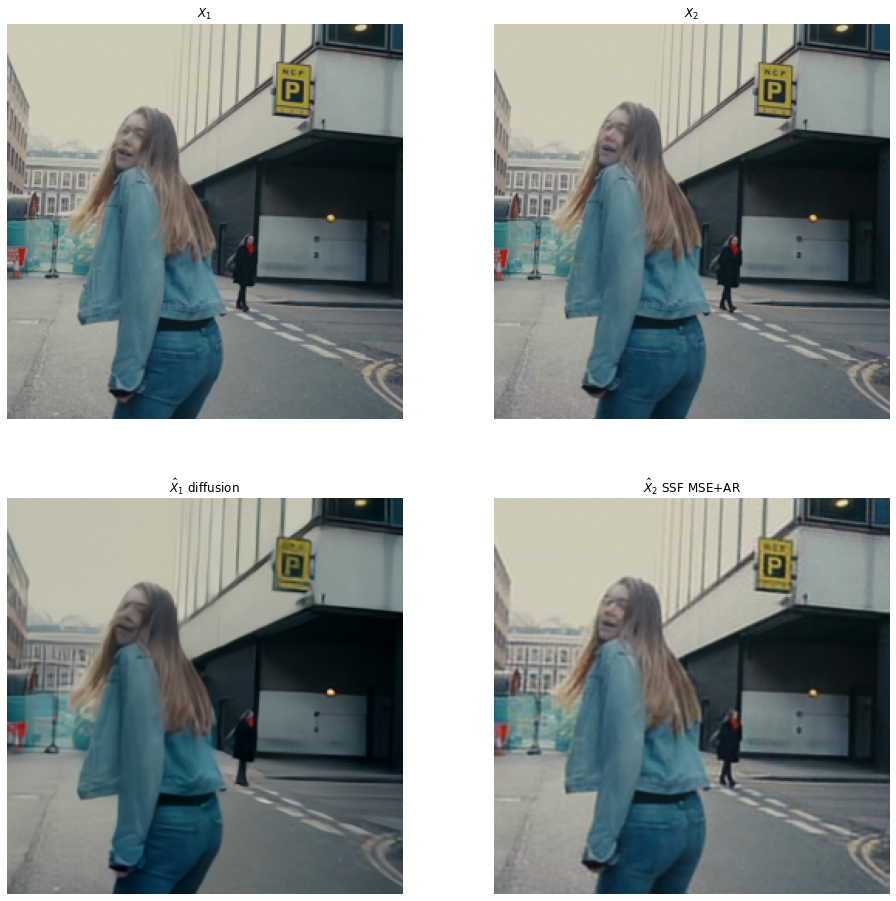

In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomCrop(256)
])

train_dataset = VideoFolder_diffusion(
    "./data/vimeo-90k/vimeo_triplet/",
    rnd_interval=False,
    rnd_temp_order=False,
    split="train",
    transform=train_transforms
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True
)

ssf = ScaleSpaceFlow().to(device)
ssf = load_ssf_model(ssf, './saved_models/vimeo-90k/AR_0.16')

x = next(iter(train_dataloader))
x1     = 2 * (x[:, 0, ...] - 0.5)
x2     = 2 * (x[:, 1, ...] - 0.5)
x1_hat = 2 * (x[:, 3, ...] - 0.5)

x1     = x1.to(device)
x2     = x2.to(device)
x1_hat = x1_hat.to(device)

ssf.eval()
x2_hat = ssf([x1_hat, x2])
x2_hat = (x2_hat - x2_hat.min()) / (x2_hat.max() - x2_hat.min())
fig, axarr = plt.subplots(2,2)
fig.set_size_inches(16, 16)

#x2_hat = 2 * (x2_hat - 0.5)
index = np.random.randint(64)
axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[1,0].axis('off')
axarr[1,1].axis('off')
axarr[0,0].set_title(r"$X_1$")
axarr[0,1].set_title(r"$X_2$")
axarr[1,0].set_title(r"$\hat{X}_1$ diffusion ")
axarr[1,1].set_title(r"$\hat{X}_2$ SSF MSE+AR")

axarr[0,0].imshow(x[index,0,...].cpu().permute(1,2,0))
axarr[0,1].imshow(x[index,1,...].cpu().permute(1,2,0))
axarr[1,0].imshow(x[index,3,...].cpu().permute(1,2,0))
axarr[1,1].imshow(x2_hat[index].detach().cpu().permute(1,2,0))
